In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
import json
import PIL
from PIL import ImageDraw, ImageFont,Image, ImageOps, ImageEnhance
from matplotlib import patches, patheffects
import numpy as np
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms,models
from torchvision.utils import make_grid
import math
import random
import numbers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm, tqdm_notebook
import glob
from skimage import io
from torch.autograd import Variable as V
from scipy import ndimage
import time
import os
import copy
import skimage
torch.backends.cudnn.benchmark=True
torch.cuda.set_device(0)
import scipy
def sum_geom(a,r,n): return a*n if r==1 else math.ceil(a*(1-r**n)/(1-r))
def is_listy(x): return isinstance(x, (list,tuple))
def is_iter(x): return isinstance(x, collections.Iterable)
def map_over(x, f): return [f(o) for o in x] if is_listy(x) else f(x)
def map_none(x, f): return None if x is None else f(x)
def delistify(x): return x[0] if is_listy(x) else x
def listify(x, y):
    if not is_iter(x): x=[x]
    n = y if type(y)==int else len(y)
    if len(x)==1: x = x * n
    return x

def datafy(x):
    if is_listy(x): return [o.data for o in x]
    else:           return x.data

conv_dict = {np.dtype('int8'): torch.LongTensor, np.dtype('int16'): torch.LongTensor,
    np.dtype('int32'): torch.LongTensor, np.dtype('int64'): torch.LongTensor,
    np.dtype('float32'): torch.FloatTensor, np.dtype('float64'): torch.FloatTensor}

def A(*a):
    """convert iterable object into numpy array"""
    return np.array(a[0]) if len(a)==1 else [np.array(o) for o in a]

def T(a, half=False, cuda=True):
    """
    Convert numpy array into a pytorch tensor. 
    if Cuda is available and USE_GPU=True, store resulting tensor in GPU.
    """
    if not torch.is_tensor(a):
        a = np.array(np.ascontiguousarray(a))
        if a.dtype in (np.int8, np.int16, np.int32, np.int64):
            a = torch.LongTensor(a.astype(np.int64))
        elif a.dtype in (np.float32, np.float64):
            a = to_half(a) if half else torch.FloatTensor(a)
        else: raise NotImplementedError(a.dtype)
    if cuda: a = to_gpu(a)
    return a

def to_half(tensor):
    if torch.cuda.is_available():
        return torch.cuda.HalfTensor(tensor)
    else:
        return torch.FloatTensor(tensor)

def create_variable(x, volatile, requires_grad=False):
    if type (x) != Variable:
        x = Variable(T(x), requires_grad=requires_grad, volatile=volatile)
    return x

def V_(x, requires_grad=False, volatile=False):
    '''equivalent to create_variable, which creates a pytorch tensor'''
    return create_variable(x, volatile=volatile, requires_grad=requires_grad)
def V(x, requires_grad=False, volatile=False):
    '''creates a single or a list of pytorch tensors, depending on input x. '''
    return map_over(x, lambda o: V_(o, requires_grad, volatile))

def VV_(x): 
    '''creates a volatile tensor, which does not require gradients. '''
    return create_variable(x, True)

def VV(x):
    '''creates a single or a list of pytorch tensors, depending on input x. '''
    return map_over(x, VV_)

def to_np(v):
    '''returns an np.array object given an input of np.array, list, tuple, torch variable or tensor.'''
    if isinstance(v, float): return np.array(v)
    if isinstance(v, (np.ndarray, np.generic)): return v
    if isinstance(v, (list,tuple)): return [to_np(o) for o in v]
    if isinstance(v, Variable): v=v.data
    if torch.cuda.is_available():
        if is_half_tensor(v): v=v.float()
    if isinstance(v, torch.FloatTensor): v=v.float()
    return v.cpu().numpy()

def is_half_tensor(v):
    return isinstance(v, torch.cuda.HalfTensor)


USE_GPU = torch.cuda.is_available()
def to_gpu(x, *args, **kwargs):
    '''puts pytorch variable to gpu, if cuda is available and USE_GPU is set to true. '''
    return x.cuda(*args, **kwargs) if USE_GPU else x

def noop(*args, **kwargs): return

def trainable_params_(m):
    '''Returns a list of trainable parameters in the model m. (i.e., those that require gradients.)'''
    return [p for p in m.parameters() if p.requires_grad]

def chain_params(p):
    if is_listy(p):
        return list(chain(*[trainable_params_(o) for o in p]))
    return trainable_params_(p)

def set_trainable_attr(m,b):
    m.trainable=b
    for p in m.parameters(): p.requires_grad=b

def apply_leaf(m, f):
    c = children(m)
    if isinstance(m, nn.Module): f(m)
    if len(c)>0:
        for l in c: apply_leaf(l,f)
def children(m): return m if isinstance(m, (list, tuple)) else list(m.children())
def set_trainable(l, b):
    apply_leaf(l, lambda m: set_trainable_attr(m,b))


In [3]:
PATH = Path('F:/Kaggle/project/PASCAL_VOC/')

In [4]:
os.listdir(PATH)

['catid_cat.json',
 'filename_box.csv',
 'filename_cate.csv',
 'filename_catss.csv',
 'id_categories.json',
 'imid_cat.csv',
 'model.h5',
 'modelSSD.h5',
 'modleSSDmoreanchors.h5',
 'modleSSDRetinaNetFocalLoss.h5',
 'pascal_test2007.json',
 'pascal_train2007.json',
 'pascal_train2012.json',
 'pascal_val2007.json',
 'pascal_val2012.json',
 'train']

In [5]:
trn = json.load((PATH/'pascal_train2007.json').open())

In [7]:
trn.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [8]:
len(trn['images'])

2501

In [9]:
trn['images'][0]

{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}

In [22]:
trn['annotations'][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [11]:
trn['categories']

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'},
 {'supercategory': 'none', 'id': 5, 'name': 'bottle'},
 {'supercategory': 'none', 'id': 6, 'name': 'bus'},
 {'supercategory': 'none', 'id': 7, 'name': 'car'},
 {'supercategory': 'none', 'id': 8, 'name': 'cat'},
 {'supercategory': 'none', 'id': 9, 'name': 'chair'},
 {'supercategory': 'none', 'id': 10, 'name': 'cow'},
 {'supercategory': 'none', 'id': 11, 'name': 'diningtable'},
 {'supercategory': 'none', 'id': 12, 'name': 'dog'},
 {'supercategory': 'none', 'id': 13, 'name': 'horse'},
 {'supercategory': 'none', 'id': 14, 'name': 'motorbike'},
 {'supercategory': 'none', 'id': 15, 'name': 'person'},
 {'supercategory': 'none', 'id': 16, 'name': 'pottedplant'},
 {'supercategory': 'none', 'id': 17, 'name': 'sheep'},
 {'supercategory': 'none', 'id': 18, 'name': 'sofa'},
 {'super

In [12]:
Imageid_Imagename={i['id']:i['file_name'] for i in trn['images']}

In [13]:
ID_CLASS={i['id']-1:i['name'] for i in trn['categories']}

In [15]:
with open(f'{PATH}/catid_cat.json', 'w') as fp:
    json.dump(ID_CLASS, fp)

In [4]:
id2cats = json.load((PATH/'catid_cat.json').open())

In [17]:
from collections import defaultdict

In [18]:
imid_cat =defaultdict(lambda:[])

In [19]:
trn['annotations'][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [23]:
for i in trn['annotations']:
    if not i['ignore']:
        imid_cat[i['image_id']].append(i['category_id']-1)

In [25]:
for i in imid_cat:
    imid_cat[i]=set(imid_cat[i])

In [26]:
csv_cat = [' '.join(str(p) for p in imid_cat[o]) for o in imid_cat]

In [27]:
csv_imid= [i for i in imid_cat]

In [28]:
df = pd.DataFrame({'image_id': csv_imid, 'categories': csv_cat}, columns=['image_id','categories'])
df.to_csv(PATH/'imid_cat.csv', index=False)

In [29]:
File_name=[Imageid_Imagename[i] for i in Imageid_Imagename]

In [30]:
df = pd.DataFrame({'file_name': File_name, 'categories': csv_cat}, columns=['file_name','categories'])
df.to_csv(PATH/'filename_cate.csv', index=False)

In [737]:
image_box =defaultdict(lambda:[])

In [738]:
for i in trn['annotations']:
    if not i['ignore']:
        image_box[i['image_id']].append(i['bbox'])

In [739]:
image_box

defaultdict(<function __main__.<lambda>()>,
            {12: [[155, 96, 196, 174]],
             17: [[184, 61, 95, 138], [89, 77, 314, 259]],
             23: [[8, 229, 237, 271],
              [229, 219, 105, 281],
              [1, 0, 116, 369],
              [2, 1, 241, 461],
              [224, 0, 110, 486]],
             26: [[89, 124, 248, 88]],
             32: [[103, 77, 272, 106],
              [132, 87, 65, 36],
              [194, 179, 19, 50],
              [25, 188, 19, 50]],
             33: [[8, 106, 491, 157], [420, 199, 62, 27], [324, 187, 87, 36]],
             34: [[115, 166, 245, 234], [140, 152, 193, 77]],
             35: [[0, 95, 191, 266], [217, 97, 248, 221]],
             36: [[26, 78, 293, 266]],
             42: [[262, 31, 238, 264], [0, 35, 235, 264]],
             44: [[0, 0, 370, 330], [98, 100, 214, 113]],
             47: [[14, 0, 445, 312], [438, 169, 49, 61]],
             48: [[57, 106, 234, 359], [1, 0, 301, 500]],
             61: [[273, 10, 164, 

In [743]:
for i in image_box:
    a=[]
    for j in image_box[i]:
        a=a+j
    image_box[i]=a

In [745]:
csv_box = [' '.join(str(p) for p in image_box[o]) for o in image_box]

In [747]:
df = pd.DataFrame({'file_name': File_name, 'box': csv_box}, columns=['file_name','box'])
df.to_csv(PATH/'filename_box.csv', index=False)

In [748]:
imid_catss =defaultdict(lambda:[])

In [749]:
for i in trn['annotations']:
    if not i['ignore']:
        imid_catss[i['image_id']].append(i['category_id']-1)

In [750]:
csv_catss = [' '.join(str(p) for p in imid_catss[o]) for o in imid_catss]

In [751]:
df = pd.DataFrame({'file_name': File_name, 'categories': csv_catss}, columns=['file_name','categories'])
df.to_csv(PATH/'filename_catss.csv', index=False)

# Multi Lebel Classification

In [5]:
def GetIndex(n, cv_idx=0, val_pct=0.2, seed=42):
    n=n-1
    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    val=idxs[idx_start:idx_start+n_val]
    val=set(val)
    train=[]
    for i in tqdm(range(n+1)):
        if(i not in val):
            train.append(i)
    return train,list(val)
def GETCSV(df):
    train_csv,val_csv=GetIndex(len(df))
    return df.iloc[train_csv],df.iloc[val_csv]

In [38]:
file=pd.read_csv(PATH/'filename_cate.csv')

In [98]:
train_csv.head(1)

,file_name,categories
0,000012.jpg,6


In [39]:
train_csv,val_csv=GETCSV(file)

100%|█████████████████████████████████████████████████████████████████████████| 2501/2501 [00:00<00:00, 2507159.25it/s]


In [117]:
data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [350]:
class DataSet(Dataset):
   
    def __init__(self, csv_file, root_dir, n_class, transform=None):
        
        self.csv_file = csv_file
        array=[]
        for i,fn in zip(csv_file['categories'],csv_file['file_name']):
            a=i.split()
            a=[int(j) for j in a]
            b=[0.0 for i in range(n_class)]
            for i in a:
                b[i]=1.0
            array.append((fn,b))
        self.file_label=array
        self.root_dir = root_dir
        self.classes=n_class
        self.transform = transform
    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.file_label[idx][0])
        images = Image.open(img_name)
        labels = self.file_label[idx][1]
        images = images
        images = self.transform(images)
        return images,torch.tensor(labels)

In [351]:
train_data=DataSet(train_csv,PATH/'train/',20,transform=data_transform)

In [352]:
valid_data=DataSet(val_csv,PATH/'train/',20,transform=data_transform)

In [353]:
train_loader=DataLoader(train_data,batch_size=15,shuffle=True ,num_workers=0 , pin_memory=True)
valid_loader=DataLoader(valid_data,batch_size=15,shuffle=True ,num_workers=0 , pin_memory=True)

In [6]:
dataloaders = {'train': train_loader,'valid':valid_loader}

NameError: name 'train_loader' is not defined

In [355]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)
    
class Flatten(nn.Module):
    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

In [387]:
model_conv = models.resnet34(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
layers=[Flatten(),nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
       nn.Dropout(p=0.25), nn.Linear(in_features=1024, out_features=512, bias=True),
       nn.ReLU(),nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
       nn.Dropout(p=0.5),nn.Linear(in_features=512, out_features=20, bias=True),nn.Sigmoid()]
model_conv.avgpool=AdaptiveConcatPool2d(1)
model_conv.fc=nn.Sequential(*layers)

In [388]:
criterion = nn.BCELoss()
model_conv = model_conv.cuda()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.04, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=0.1)

In [390]:
dataset_sizes={'train':len(train_data),'valid':len(valid_data)}

In [478]:
def accuracy_thresh(y_pred, y_true, thresh:float=0.7, sigmoid:bool=True):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: y_pred = y_pred.sigmoid()
    return ((y_pred>thresh)==y_true.byte()).float().mean()
def Accuracy(model):
    was_training = model.training
    model.eval()
    acc=0.0
    with torch.no_grad():
        k=0
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            acc+=accuracy_thresh(outputs,labels)
            k+=1
        print(acc/k)
        model.train(mode=was_training)

In [505]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

    
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            
                running_loss += loss.item() * inputs.size(0)
                running_corrects += accuracy_thresh(outputs,labels)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
                phase, epoch_loss , epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [394]:
model_conv = train_model(model, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
train Loss: 0.3967
valid Loss: 0.1510

Epoch 1/2
----------
train Loss: 0.1396
valid Loss: 0.1147

Epoch 2/2
----------
train Loss: 0.1206
valid Loss: 0.1019

Training complete in 4m 20s


In [451]:
torch.save(model_conv.state_dict(), PATH/'model.h5')

In [471]:
model_conv.load_state_dict(torch.load(PATH/'model.h5'), strict=False)

In [450]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.1072
valid Loss: 0.1003

Epoch 1/9
----------
train Loss: 0.1081
valid Loss: 0.1010

Epoch 2/9
----------
train Loss: 0.1048
valid Loss: 0.0998

Epoch 3/9
----------
train Loss: 0.1061
valid Loss: 0.1005

Epoch 4/9
----------
train Loss: 0.1053
valid Loss: 0.0995

Epoch 5/9
----------
train Loss: 0.1021
valid Loss: 0.1014

Epoch 6/9
----------
train Loss: 0.1048
valid Loss: 0.1016

Epoch 7/9
----------
train Loss: 0.1038
valid Loss: 0.1006

Epoch 8/9
----------
train Loss: 0.1046
valid Loss: 0.1010

Epoch 9/9
----------
train Loss: 0.1040
valid Loss: 0.0973

Training complete in 14m 30s


In [479]:
torch.save(model_conv.state_dict(), PATH/'model.h5')

In [480]:
model_conv.load_state_dict(torch.load(PATH/'model.h5'), strict=False)

In [486]:
a=model_conv.conv1

In [506]:
model_conv = models.resnet34(pretrained=True)
layers=[Flatten(),nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
       nn.Dropout(p=0.25), nn.Linear(in_features=1024, out_features=512, bias=True),
       nn.ReLU(),nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
       nn.Dropout(p=0.5),nn.Linear(in_features=512, out_features=20, bias=True),nn.Sigmoid()]
model_conv.avgpool=AdaptiveConcatPool2d(1)
model_conv.fc=nn.Sequential(*layers)

In [507]:
model_conv.load_state_dict(torch.load(PATH/'model.h5'), strict=False)

In [508]:
criterion = nn.BCELoss()
model_conv = model_conv.cuda()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.004, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=0.1)

In [509]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------







  0%|                                                                                          | 0/134 [00:00<?, ?it/s]




  1%|▌                                                                                 | 1/134 [00:01<03:10,  1.43s/it]




  1%|█▏                                                                                | 2/134 [00:02<03:09,  1.44s/it]




  2%|█▊                                                                                | 3/134 [00:04<03:08,  1.44s/it]




  3%|██▍                                                                               | 4/134 [00:05<03:07,  1.44s/it]




  4%|███                                                                               | 5/134 [00:07<03:06,  1.44s/it]




  4%|███▋                                                                              | 6/134 [00:08<03:05,  1.45s/it]




  5%|████▎                                                                             | 7/134 [00:10<03:04,  1.45s/it]




  6

 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:11<00:02,  1.46s/it]




 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:12<00:01,  1.46s/it]




100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:13<00:00,  1.24s/it]






train Loss: 0.1040 Accuracy: 0.0637







  0%|                                                                                           | 0/34 [00:00<?, ?it/s]




  3%|██▍                                                                                | 1/34 [00:00<00:16,  1.96it/s]




  6%|████▉                                                                              | 2/34 [00:01<00:16,  1.97it/s]




  9%|███████▎                                                                           | 3/34 [00:01<00:15,  1.96it/s]




 12%|█████████▊                                                                         | 4/34 [00:02<00:15,  1.95it/s]




 15%|████████████▏                                                                      | 5/34 [00:02<00:14,  1.97it/s]




 18%|██████████████▋                                                                    | 6/34 [00:03<00:14,  1.96it/s]




 21%|█████████████████                                                                  | 7/34 [00:03<00:13,  1.95it/s]




 24

valid Loss: 0.1009 Accuracy: 0.0646

Epoch 1/2
----------







  0%|                                                                                          | 0/134 [00:00<?, ?it/s]




  1%|▌                                                                                 | 1/134 [00:01<03:12,  1.44s/it]




  1%|█▏                                                                                | 2/134 [00:02<03:10,  1.45s/it]




  2%|█▊                                                                                | 3/134 [00:04<03:09,  1.45s/it]




  3%|██▍                                                                               | 4/134 [00:05<03:08,  1.45s/it]




  4%|███                                                                               | 5/134 [00:07<03:06,  1.44s/it]




  4%|███▋                                                                              | 6/134 [00:08<03:04,  1.44s/it]




  5%|████▎                                                                             | 7/134 [00:10<03:03,  1.44s/it]




  6

 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:11<00:02,  1.45s/it]




 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:13<00:01,  1.46s/it]




100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:14<00:00,  1.24s/it]






train Loss: 0.1028 Accuracy: 0.0637







  0%|                                                                                           | 0/34 [00:00<?, ?it/s]




  3%|██▍                                                                                | 1/34 [00:00<00:16,  1.97it/s]




  6%|████▉                                                                              | 2/34 [00:01<00:16,  1.96it/s]




  9%|███████▎                                                                           | 3/34 [00:01<00:15,  1.96it/s]




 12%|█████████▊                                                                         | 4/34 [00:02<00:15,  1.96it/s]




 15%|████████████▏                                                                      | 5/34 [00:02<00:14,  1.95it/s]




 18%|██████████████▋                                                                    | 6/34 [00:03<00:14,  1.96it/s]




 21%|█████████████████                                                                  | 7/34 [00:03<00:13,  1.95it/s]




 24

valid Loss: 0.1000 Accuracy: 0.0646

Epoch 2/2
----------







  0%|                                                                                          | 0/134 [00:00<?, ?it/s]




  1%|▌                                                                                 | 1/134 [00:01<03:13,  1.46s/it]




  1%|█▏                                                                                | 2/134 [00:02<03:11,  1.45s/it]




  2%|█▊                                                                                | 3/134 [00:04<03:10,  1.46s/it]




  3%|██▍                                                                               | 4/134 [00:05<03:09,  1.45s/it]




  4%|███                                                                               | 5/134 [00:07<03:07,  1.45s/it]




  4%|███▋                                                                              | 6/134 [00:08<03:05,  1.45s/it]




  5%|████▎                                                                             | 7/134 [00:10<03:04,  1.45s/it]




  6

 99%|██████████████████████████████████████████████████████████████████████████████▊ | 132/134 [03:11<00:02,  1.45s/it]




 99%|███████████████████████████████████████████████████████████████████████████████▍| 133/134 [03:13<00:01,  1.45s/it]




100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [03:13<00:00,  1.24s/it]






train Loss: 0.1020 Accuracy: 0.0637







  0%|                                                                                           | 0/34 [00:00<?, ?it/s]




  3%|██▍                                                                                | 1/34 [00:00<00:16,  1.94it/s]




  6%|████▉                                                                              | 2/34 [00:01<00:16,  1.91it/s]




  9%|███████▎                                                                           | 3/34 [00:01<00:16,  1.93it/s]




 12%|█████████▊                                                                         | 4/34 [00:02<00:15,  1.92it/s]




 15%|████████████▏                                                                      | 5/34 [00:02<00:15,  1.91it/s]




 18%|██████████████▋                                                                    | 6/34 [00:03<00:14,  1.91it/s]




 21%|█████████████████                                                                  | 7/34 [00:03<00:14,  1.93it/s]




 24

valid Loss: 0.0972 Accuracy: 0.0648

Training complete in 10m 34s
Best val Acc: 0.064813


In [510]:
Accuracy(model_conv)

tensor(0.9531, device='cuda:0')


we are getting 95.31% accuracy on validation set,the model is preety good, now we can move towards 
multiple object detection in images 

Now before loading the data and we are going to make the architecture of our model then we will see the output then according to our output we will load the data into dataloader

In [5]:
k=1
n_clas = 21
n_act = k*(4+n_clas)

In [6]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [7]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (20+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [8]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv2(x)
        return self.out(x)

In [9]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x 

In [10]:
model_conv = models.resnet34(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
model_conv = torch.nn.Sequential(*(list(model_conv.children())[:-1]))
z=Identity()
p=SSD_Head(k,-3)
p = nn.Sequential(z,*list(p.children()))
model_conv[8]=p

In [11]:
pdc=model_conv(torch.rand(2,3,224,224))

In [12]:
anc_grid = 4
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [13]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

In [14]:
grid_sizes=grid_sizes.float()

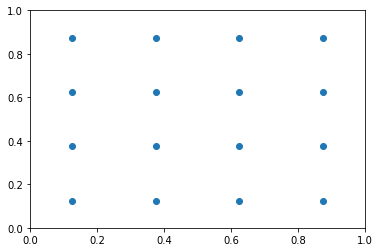

In [15]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [7]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [17]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [18]:
anchor_cnr

tensor([[0.0000, 0.0000, 0.2500, 0.2500],
        [0.0000, 0.2500, 0.2500, 0.5000],
        [0.0000, 0.5000, 0.2500, 0.7500],
        [0.0000, 0.7500, 0.2500, 1.0000],
        [0.2500, 0.0000, 0.5000, 0.2500],
        [0.2500, 0.2500, 0.5000, 0.5000],
        [0.2500, 0.5000, 0.5000, 0.7500],
        [0.2500, 0.7500, 0.5000, 1.0000],
        [0.5000, 0.0000, 0.7500, 0.2500],
        [0.5000, 0.2500, 0.7500, 0.5000],
        [0.5000, 0.5000, 0.7500, 0.7500],
        [0.5000, 0.7500, 0.7500, 1.0000],
        [0.7500, 0.0000, 1.0000, 0.2500],
        [0.7500, 0.2500, 1.0000, 0.5000],
        [0.7500, 0.5000, 1.0000, 0.7500],
        [0.7500, 0.7500, 1.0000, 1.0000]], device='cuda:0')

In [19]:
anchors

tensor([[0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.8750, 0.2500, 0.2500],
        [0.3750, 0.1250, 0.2500, 0.2500],
        [0.3750, 0.3750, 0.2500, 0.2500],
        [0.3750, 0.6250, 0.2500, 0.2500],
        [0.3750, 0.8750, 0.2500, 0.2500],
        [0.6250, 0.1250, 0.2500, 0.2500],
        [0.6250, 0.3750, 0.2500, 0.2500],
        [0.6250, 0.6250, 0.2500, 0.2500],
        [0.6250, 0.8750, 0.2500, 0.2500],
        [0.8750, 0.1250, 0.2500, 0.2500],
        [0.8750, 0.3750, 0.2500, 0.2500],
        [0.8750, 0.6250, 0.2500, 0.2500],
        [0.8750, 0.8750, 0.2500, 0.2500]], device='cuda:0')

In [20]:
def one_hot_embedding(labels, num_classes):
    labels=labels.type(torch.long)
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        x=x.type(torch.FloatTensor)
        t=t.type(torch.FloatTensor)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None # when we will use Focal loss we will write code for this

loss_f = BCE_Loss(20)

In [21]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [8]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = 20
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

Now we are going to check the model and loss function how it work 

In [91]:
a=next(iter(valid_loader))

In [92]:
a[0].shape

torch.Size([8, 3, 224, 224])

In [93]:
batch=model(a[0].cuda())
b_clas,b_bb = batch

In [94]:
idx=1
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=a[0][idx]
ima=ima.permute(1,2,0)
ima=np.array(ima)
bbox,clas = get_y(a[1][0][idx], a[1][1][idx])
bbox,clas

(tensor([[0.0570, 0.0040, 1.0000, 0.2280],
         [0.1678, 0.2160, 0.9966, 0.4280],
         [0.1141, 0.4220, 0.9966, 0.6320],
         [0.1074, 0.5760, 0.9966, 0.7740],
         [0.0470, 0.7600, 0.9966, 1.0000]]), tensor([14., 14., 14., 14., 14.]))

In [9]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[str(c)])

            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

TypeError: show_img() got an unexpected keyword argument 'ax'

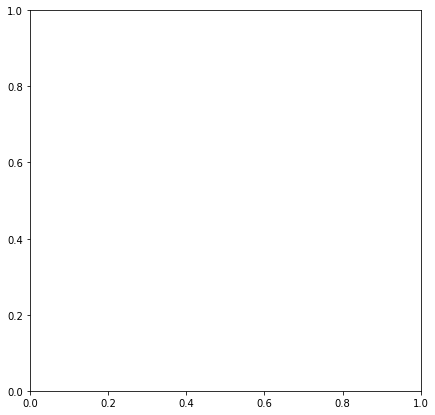

In [112]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


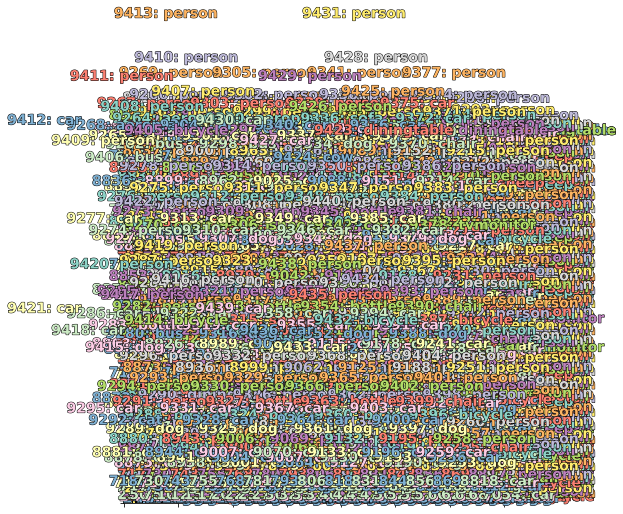

In [99]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

In [99]:
grid_sizes=grid_sizes.cuda()

In [100]:
a_ic = encode_gt2anc(b_bboxi.cuda(), anchors.cuda())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


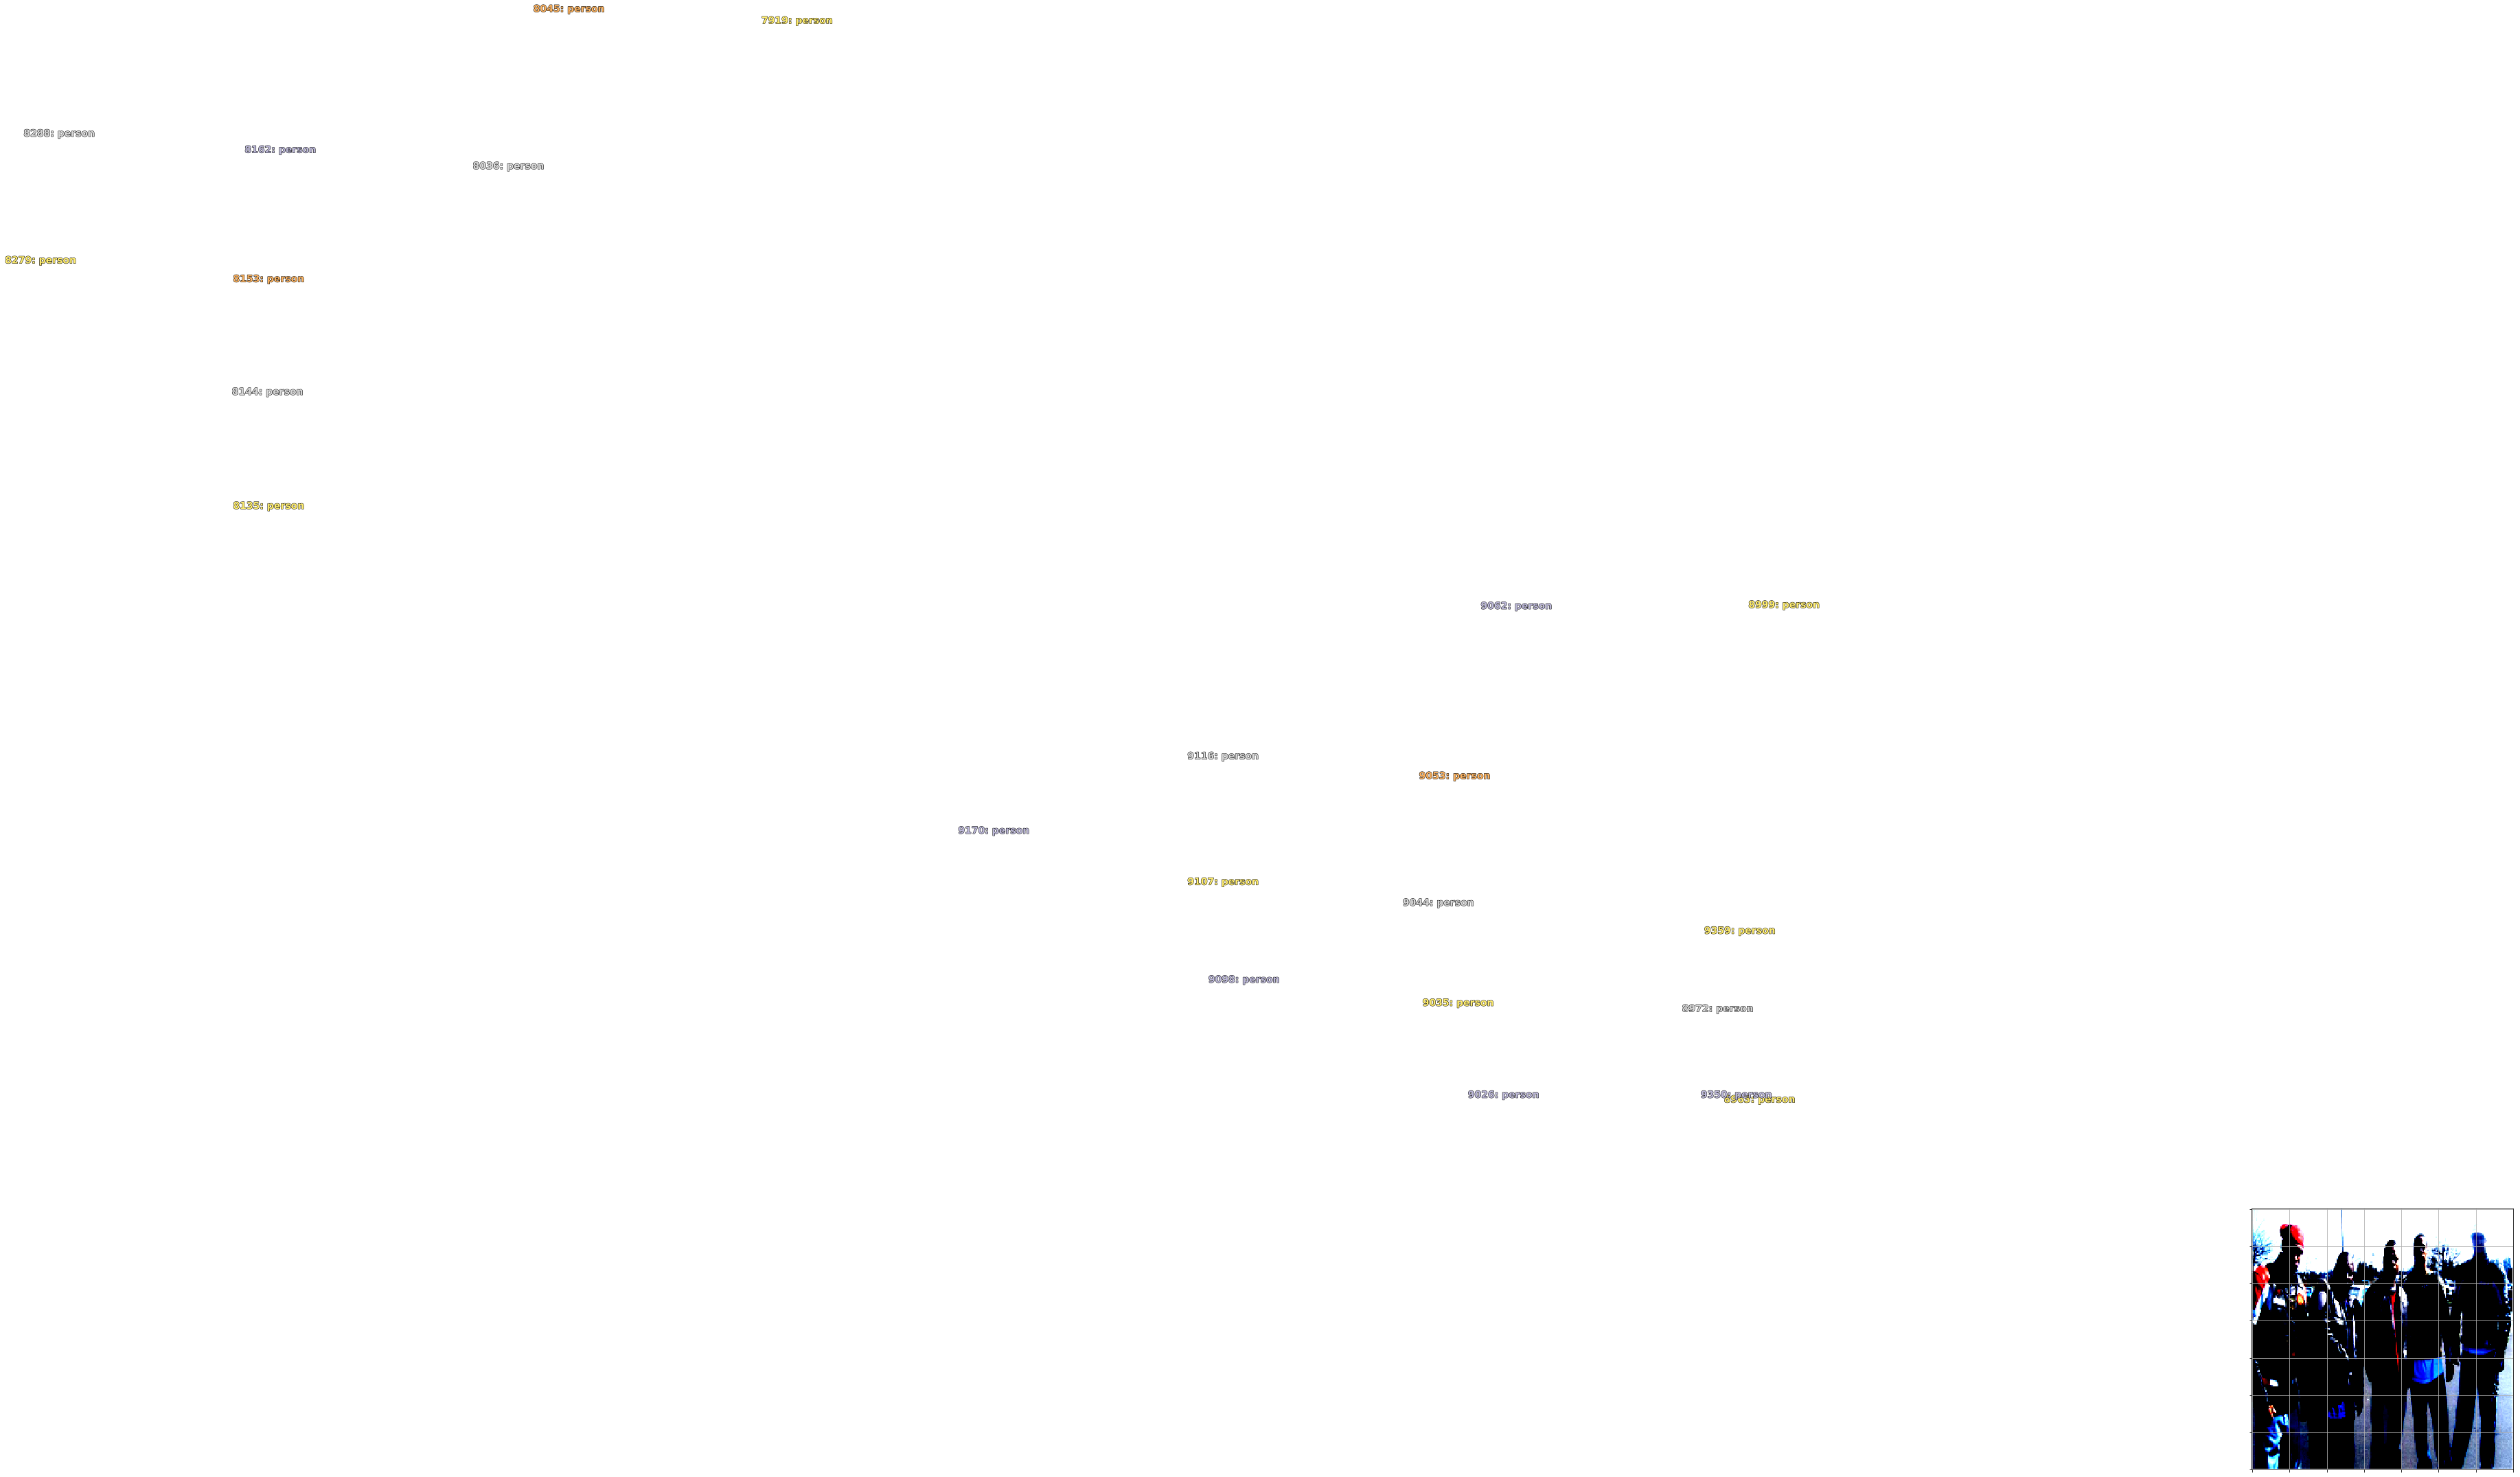

In [107]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.012)

Data loading for Object Detection

In [6]:
def hw_bb(a): return np.array([a[1],a[0],a[3]+a[1],a[2]+a[0]])

In [7]:
class DataSet1(Dataset):
    def __init__(self, csv_box,csv_class ,root_dir, transform=None):
        X=0
        arr1=[]
        arr2=[]
        for i in csv_class['categories']:
            a=i.split()
            a=list(a)
            X=max(len(a),X)
        print(X)
        for i,fn in zip(csv_class['categories'],csv_class['file_name']):
            a=i.split()
            a=[float(j) for j in a]
            s=len(a)
            for j in range(X-s):
                a.insert(0,0.0)
            arr1.append((fn,a))
        for i,fn in zip(csv_box['box'],csv_box['file_name']):
            a=i.split()
            a=[float(j) for j in a]
            s=len(a)
            img_name = os.path.join(root_dir,fn)
            img=plt.imread(img_name)
            x,y,z=img.shape
            for j in range(0,s,4):
                p=hw_bb([a[j],a[j+1],a[j+2],a[j+3]])
                a[j],a[j+1],a[j+2],a[j+3]=p[0]*224/x,p[1]*224/y,p[2]*224/x,p[3]*224/y,
            for j in range(4*X-s):
                a.insert(0,0.0)
            arr2.append((fn,a))
        self.csv_box=csv_box
        self.csv_class=csv_class
        self.file_label1=arr2
        self.file_label2=arr1
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.csv_box)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.file_label1[idx][0])
        img=plt.imread(img_name)
        x,y,z=img.shape
        images = Image.open(img_name)
        labels1 = self.file_label1[idx][1]
        labels2 = self.file_label2[idx][1]
        labels1=torch.tensor(labels1).float()
        labels2=torch.tensor(labels2).float()
        
        images = self.transform(images).float()
        return images,(labels1,labels2)

In [8]:
f1,f2=pd.read_csv(PATH/'filename_box.csv'),pd.read_csv(PATH/'filename_catss.csv')

In [9]:
train_box,val_box=GETCSV(f1)
train_class,val_class=GETCSV(f2)

100%|██████████████████████████████████████████████████████████████████████████| 2501/2501 [00:00<00:00, 627202.05it/s]


In [10]:
data_transform1 = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [11]:
train_data=DataSet1(train_box,train_class,PATH/'train/',transform=data_transform1)

17


In [12]:
valid_data=DataSet1(val_box,val_class,PATH/'train/',transform=data_transform1)

19


In [13]:
dataset_sizes={'train':len(train_data),'valid':len(valid_data)}

In [14]:
train_loader=DataLoader(train_data,batch_size=8,shuffle=True ,num_workers=0 , pin_memory=True)
valid_loader=DataLoader(valid_data,batch_size=8,shuffle=True ,num_workers=0 , pin_memory=True)

In [16]:
dataloaders = {'train': train_loader,'valid':valid_loader}

In [35]:
criterion = ssd_loss
model_conv = model_conv.cuda()
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.004, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=0.1)

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()

            running_loss = 0.0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs[0]=outputs[0].cpu()
                    outputs[1]=outputs[1].cpu()
                    loss = criterion(outputs, labels)
                    print(loss)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
            
                running_loss += loss.item() * inputs.size(0)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            print('{} Loss: {:.4f} '.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'valid' :
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    model.load_state_dict(best_model_wts)
    return model

In [17]:
torch.backends.cudnn.benchmark=True

In [18]:
sz=224

In [52]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=9)

Epoch 0/8
----------
tensor(19.4063, grad_fn=<AddBackward0>)
tensor(19.7838, grad_fn=<AddBackward0>)
tensor(21.8808, grad_fn=<AddBackward0>)
tensor(19.4338, grad_fn=<AddBackward0>)
tensor(17.2634, grad_fn=<AddBackward0>)
tensor(16.2150, grad_fn=<AddBackward0>)
tensor(17.2444, grad_fn=<AddBackward0>)
tensor(15.4956, grad_fn=<AddBackward0>)
tensor(16.8763, grad_fn=<AddBackward0>)
tensor(17.5533, grad_fn=<AddBackward0>)
tensor(14.5954, grad_fn=<AddBackward0>)
tensor(13.6943, grad_fn=<AddBackward0>)
tensor(13.4324, grad_fn=<AddBackward0>)
tensor(11.5061, grad_fn=<AddBackward0>)
tensor(13.8910, grad_fn=<AddBackward0>)
tensor(12.2297, grad_fn=<AddBackward0>)
tensor(10.9844, grad_fn=<AddBackward0>)
tensor(9.7860, grad_fn=<AddBackward0>)
tensor(11.6367, grad_fn=<AddBackward0>)
tensor(12.7808, grad_fn=<AddBackward0>)
tensor(9.1290, grad_fn=<AddBackward0>)
tensor(10.1570, grad_fn=<AddBackward0>)
tensor(9.2990, grad_fn=<AddBackward0>)
tensor(10.0109, grad_fn=<AddBackward0>)
tensor(12.2060, grad_f

tensor(6.9213, grad_fn=<AddBackward0>)
tensor(5.3833, grad_fn=<AddBackward0>)
tensor(5.6874, grad_fn=<AddBackward0>)
tensor(7.0728, grad_fn=<AddBackward0>)
tensor(6.6123, grad_fn=<AddBackward0>)
tensor(6.1350, grad_fn=<AddBackward0>)
tensor(7.7556, grad_fn=<AddBackward0>)
tensor(6.5048, grad_fn=<AddBackward0>)
tensor(6.4456, grad_fn=<AddBackward0>)
tensor(5.5576, grad_fn=<AddBackward0>)
tensor(6.0164, grad_fn=<AddBackward0>)
tensor(5.7614, grad_fn=<AddBackward0>)
tensor(1.9827, grad_fn=<AddBackward0>)
train Loss: 6.2471 
tensor(6.7339)
tensor(6.0953)
tensor(8.2629)
tensor(7.3725)
tensor(6.1659)
tensor(7.8337)
tensor(8.8090)
tensor(6.8105)
tensor(5.8968)
tensor(7.3815)
tensor(7.1553)
tensor(5.7290)
tensor(6.4979)
tensor(8.2587)
tensor(6.9396)
tensor(7.9918)
tensor(7.1397)
tensor(6.3327)
tensor(7.5861)
tensor(6.9342)
tensor(5.2891)
tensor(7.0977)
tensor(6.3455)
tensor(5.6625)
tensor(6.5737)
tensor(8.5985)
tensor(7.6191)
tensor(6.8302)
tensor(7.0174)
tensor(7.1439)
tensor(6.6039)
tensor(5

tensor(5.0562, grad_fn=<AddBackward0>)
tensor(5.2447, grad_fn=<AddBackward0>)
tensor(6.3911, grad_fn=<AddBackward0>)
tensor(4.9224, grad_fn=<AddBackward0>)
tensor(5.8485, grad_fn=<AddBackward0>)
tensor(5.7901, grad_fn=<AddBackward0>)
tensor(5.3734, grad_fn=<AddBackward0>)
tensor(4.9275, grad_fn=<AddBackward0>)
tensor(5.5012, grad_fn=<AddBackward0>)
tensor(4.6291, grad_fn=<AddBackward0>)
tensor(5.1737, grad_fn=<AddBackward0>)
tensor(5.9370, grad_fn=<AddBackward0>)
tensor(5.8774, grad_fn=<AddBackward0>)
tensor(5.2190, grad_fn=<AddBackward0>)
tensor(5.2474, grad_fn=<AddBackward0>)
tensor(5.9330, grad_fn=<AddBackward0>)
tensor(5.1415, grad_fn=<AddBackward0>)
tensor(5.8761, grad_fn=<AddBackward0>)
tensor(6.1815, grad_fn=<AddBackward0>)
tensor(5.4201, grad_fn=<AddBackward0>)
tensor(4.9007, grad_fn=<AddBackward0>)
tensor(4.8860, grad_fn=<AddBackward0>)
tensor(6.6675, grad_fn=<AddBackward0>)
tensor(6.3837, grad_fn=<AddBackward0>)
tensor(4.7342, grad_fn=<AddBackward0>)
tensor(5.1210, grad_fn=<A

tensor(4.9509, grad_fn=<AddBackward0>)
tensor(5.2778, grad_fn=<AddBackward0>)
tensor(4.1309, grad_fn=<AddBackward0>)
tensor(6.8701, grad_fn=<AddBackward0>)
tensor(6.4079, grad_fn=<AddBackward0>)
tensor(5.9267, grad_fn=<AddBackward0>)
tensor(4.3891, grad_fn=<AddBackward0>)
tensor(5.5517, grad_fn=<AddBackward0>)
tensor(5.4725, grad_fn=<AddBackward0>)
tensor(4.8997, grad_fn=<AddBackward0>)
tensor(4.9929, grad_fn=<AddBackward0>)
tensor(5.4460, grad_fn=<AddBackward0>)
tensor(4.5235, grad_fn=<AddBackward0>)
tensor(6.6595, grad_fn=<AddBackward0>)
tensor(7.0164, grad_fn=<AddBackward0>)
tensor(5.3236, grad_fn=<AddBackward0>)
tensor(4.9928, grad_fn=<AddBackward0>)
tensor(4.4832, grad_fn=<AddBackward0>)
tensor(6.1146, grad_fn=<AddBackward0>)
tensor(4.7280, grad_fn=<AddBackward0>)
tensor(5.5215, grad_fn=<AddBackward0>)
tensor(6.6556, grad_fn=<AddBackward0>)
tensor(5.1932, grad_fn=<AddBackward0>)
tensor(4.7358, grad_fn=<AddBackward0>)
tensor(6.0894, grad_fn=<AddBackward0>)
tensor(7.2323, grad_fn=<A

In [53]:
torch.save(model_conv.state_dict(), PATH/'modelSSD.h5')

In [39]:
model_conv.load_state_dict(torch.load(PATH/'modelSSD.h5'), strict=False)

In [56]:
def Accuracy(model):
    was_training = model.training
    model.eval()
    
    with torch.no_grad():
        a=next(iter(valid_loader))
        x=model(a[0].cuda())
        img=a[0][2].permute(1,2,0)
        print(x[0][2],x[1][2])
        print(a[1][0][2],a[1][1][2])
        img=np.array(img)
        plt.imshow(img)
        model.train(mode=was_training)

In [55]:
model_conv.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [109]:
model_conv.train()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

tensor([[ -7.5083,  -7.5518,  -7.7661,  -7.9202,  -6.9000,  -8.0980,  -7.5790,
          -7.3067,  -6.7088,  -7.8839,  -7.4769,  -7.7659,  -7.5967,  -8.4302,
          -5.7563,  -5.0605,  -7.4189,  -7.3979,  -8.0145,  -5.3764,  -2.8062],
        [ -8.4412,  -9.1725,  -9.0393,  -9.2615,  -7.1767, -10.1515,  -9.7726,
          -8.4573,  -7.6453,  -9.5950,  -8.7241,  -9.1441,  -9.2803,  -9.7797,
          -6.3914,  -4.9357,  -8.9540,  -8.6262,  -9.5835,  -5.7700,  -2.4574],
        [ -8.6224,  -9.5909,  -9.2930,  -9.4263,  -6.7474, -10.3776,  -9.4874,
          -8.8917,  -8.0916, -10.0351,  -9.5543, -10.5345,  -9.7344,  -9.9821,
          -7.7690,  -5.5970,  -9.7311,  -9.5660, -10.3694,  -7.1646,  -2.5951],
        [ -7.7197,  -8.2940,  -8.4300,  -7.8146,  -6.1702,  -8.2039,  -8.0575,
          -8.2310,  -7.8188,  -8.6295,  -8.1956,  -9.5237,  -8.3562,  -8.6640,
          -8.1355,  -6.0995,  -8.0076,  -7.7831,  -8.7758,  -6.5404,  -3.0544],
        [ -7.9374,  -6.6851,  -7.9196,  -6.6916,

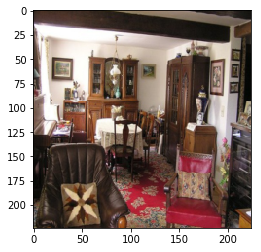

In [57]:
Accuracy(model_conv)

I have checked my model's output, it is more or less pridicting the correct but the problem is that our anchor boxes are of small size and unable to get bigger object so now we are going to have more anchor box of larger size and we will change our model head accordingly but the loss function is going to be the smae as before.

making anchor boxes

In [24]:
anc_grids = [4,2,1]
anc_zooms = [0.7, 1., 1.3]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

9

In [25]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [99]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [103]:
anchors

tensor([[0.1250, 0.1250, 0.1750, 0.1750],
        [0.1250, 0.1250, 0.1750, 0.0875],
        [0.1250, 0.1250, 0.0875, 0.1750],
        [0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.1250, 0.2500, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.2500],
        [0.1250, 0.1250, 0.3250, 0.3250],
        [0.1250, 0.1250, 0.3250, 0.1625],
        [0.1250, 0.1250, 0.1625, 0.3250],
        [0.1250, 0.3750, 0.1750, 0.1750],
        [0.1250, 0.3750, 0.1750, 0.0875],
        [0.1250, 0.3750, 0.0875, 0.1750],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.1250],
        [0.1250, 0.3750, 0.1250, 0.2500],
        [0.1250, 0.3750, 0.3250, 0.3250],
        [0.1250, 0.3750, 0.3250, 0.1625],
        [0.1250, 0.3750, 0.1625, 0.3250],
        [0.1250, 0.6250, 0.1750, 0.1750],
        [0.1250, 0.6250, 0.1750, 0.0875],
        [0.1250, 0.6250, 0.0875, 0.1750],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.1250],
        [0.1250, 0.6250, 0.1250, 0

In [148]:
drop=0.4
class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512,256, stride=1, drop=drop)
        self.sconv1 = StdConv(256,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

In [149]:
model_conv = models.resnet34(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
model_conv = torch.nn.Sequential(*(list(model_conv.children())[:-1]))
model_conv[8]=SSD_MultiHead(k,-3)
#p=SSD_MultiHead(k,-3)
#p = nn.Sequential(z,*list(p.children()))
#model_conv[8]=p

In [132]:
model_conv

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [133]:
pdc=model_conv(torch.rand(2,3,224,224))

In [150]:
criterion = ssd_loss
model_conv = model_conv.cuda()
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.02, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=0.1)

In [151]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
tensor(160.8411, grad_fn=<AddBackward0>)
tensor(157.6660, grad_fn=<AddBackward0>)
tensor(148.2012, grad_fn=<AddBackward0>)
tensor(128.8322, grad_fn=<AddBackward0>)
tensor(104.0451, grad_fn=<AddBackward0>)
tensor(78.4031, grad_fn=<AddBackward0>)
tensor(54.3823, grad_fn=<AddBackward0>)
tensor(41.2669, grad_fn=<AddBackward0>)
tensor(36.3588, grad_fn=<AddBackward0>)
tensor(30.2108, grad_fn=<AddBackward0>)
tensor(34.2406, grad_fn=<AddBackward0>)
tensor(35.6068, grad_fn=<AddBackward0>)
tensor(43.0485, grad_fn=<AddBackward0>)
tensor(41.5760, grad_fn=<AddBackward0>)
tensor(54.3349, grad_fn=<AddBackward0>)
tensor(45.2327, grad_fn=<AddBackward0>)
tensor(28.1401, grad_fn=<AddBackward0>)
tensor(37.7139, grad_fn=<AddBackward0>)
tensor(39.0387, grad_fn=<AddBackward0>)
tensor(42.2333, grad_fn=<AddBackward0>)
tensor(33.0538, grad_fn=<AddBackward0>)
tensor(50.1388, grad_fn=<AddBackward0>)
tensor(38.4253, grad_fn=<AddBackward0>)
tensor(50.0790, grad_fn=<AddBackward0>)
tensor(44.295

tensor(31.2226, grad_fn=<AddBackward0>)
tensor(19.3517, grad_fn=<AddBackward0>)
tensor(37.8563, grad_fn=<AddBackward0>)
tensor(23.6382, grad_fn=<AddBackward0>)
tensor(27.1877, grad_fn=<AddBackward0>)
tensor(23.7618, grad_fn=<AddBackward0>)
tensor(27.0752, grad_fn=<AddBackward0>)
tensor(24.8117, grad_fn=<AddBackward0>)
tensor(22.6571, grad_fn=<AddBackward0>)
tensor(30.5624, grad_fn=<AddBackward0>)
tensor(19.3410, grad_fn=<AddBackward0>)
tensor(22.7095, grad_fn=<AddBackward0>)
tensor(22.8345, grad_fn=<AddBackward0>)
tensor(19.4955, grad_fn=<AddBackward0>)
tensor(26.8642, grad_fn=<AddBackward0>)
tensor(21.6340, grad_fn=<AddBackward0>)
tensor(24.2573, grad_fn=<AddBackward0>)
tensor(21.8894, grad_fn=<AddBackward0>)
tensor(26.0094, grad_fn=<AddBackward0>)
tensor(23.7203, grad_fn=<AddBackward0>)
tensor(19.3979, grad_fn=<AddBackward0>)
tensor(33.3948, grad_fn=<AddBackward0>)
tensor(21.2631, grad_fn=<AddBackward0>)
tensor(16.3210, grad_fn=<AddBackward0>)
tensor(18.0588, grad_fn=<AddBackward0>)


tensor(20.9201, grad_fn=<AddBackward0>)
tensor(20.0091, grad_fn=<AddBackward0>)
tensor(25.7257, grad_fn=<AddBackward0>)
tensor(13.8319, grad_fn=<AddBackward0>)
tensor(18.1396, grad_fn=<AddBackward0>)
tensor(17.9776, grad_fn=<AddBackward0>)
tensor(19.6143, grad_fn=<AddBackward0>)
tensor(29.0127, grad_fn=<AddBackward0>)
tensor(20.3787, grad_fn=<AddBackward0>)
tensor(19.9655, grad_fn=<AddBackward0>)
tensor(17.8984, grad_fn=<AddBackward0>)
tensor(21.0605, grad_fn=<AddBackward0>)
tensor(18.0197, grad_fn=<AddBackward0>)
tensor(20.6534, grad_fn=<AddBackward0>)
tensor(17.0659, grad_fn=<AddBackward0>)
tensor(16.5953, grad_fn=<AddBackward0>)
tensor(15.6524, grad_fn=<AddBackward0>)
tensor(18.5582, grad_fn=<AddBackward0>)
tensor(17.4337, grad_fn=<AddBackward0>)
tensor(19.9328, grad_fn=<AddBackward0>)
tensor(22.8449, grad_fn=<AddBackward0>)
tensor(26.1829, grad_fn=<AddBackward0>)
tensor(20.4499, grad_fn=<AddBackward0>)
tensor(19.0241, grad_fn=<AddBackward0>)
tensor(17.0509, grad_fn=<AddBackward0>)


tensor(14.4637, grad_fn=<AddBackward0>)
tensor(15.1452, grad_fn=<AddBackward0>)
tensor(19.9179, grad_fn=<AddBackward0>)
tensor(17.1391, grad_fn=<AddBackward0>)
tensor(19.3227, grad_fn=<AddBackward0>)
tensor(19.0773, grad_fn=<AddBackward0>)
tensor(16.1930, grad_fn=<AddBackward0>)
tensor(22.6150, grad_fn=<AddBackward0>)
tensor(14.7570, grad_fn=<AddBackward0>)
tensor(16.0614, grad_fn=<AddBackward0>)
tensor(22.1753, grad_fn=<AddBackward0>)
tensor(22.1549, grad_fn=<AddBackward0>)
tensor(16.8339, grad_fn=<AddBackward0>)
tensor(22.0082, grad_fn=<AddBackward0>)
tensor(18.6440, grad_fn=<AddBackward0>)
tensor(16.8390, grad_fn=<AddBackward0>)
tensor(21.6730, grad_fn=<AddBackward0>)
tensor(23.8508, grad_fn=<AddBackward0>)
tensor(16.6970, grad_fn=<AddBackward0>)
tensor(15.6694, grad_fn=<AddBackward0>)
tensor(19.6838, grad_fn=<AddBackward0>)
tensor(18.1808, grad_fn=<AddBackward0>)
tensor(20.0827, grad_fn=<AddBackward0>)
tensor(18.7149, grad_fn=<AddBackward0>)
tensor(29.4847, grad_fn=<AddBackward0>)


tensor(23.2790)
tensor(26.5146)
tensor(21.6546)
tensor(14.1701)
tensor(29.9930)
tensor(23.2975)
tensor(24.2908)
tensor(19.9302)
tensor(31.1793)
tensor(17.3563)
tensor(19.0408)
tensor(15.0316)
tensor(22.5856)
tensor(26.5564)
tensor(18.1482)
tensor(27.4393)
tensor(4.0694)
valid Loss: 21.4666 

Epoch 11/19
----------
tensor(27.2767, grad_fn=<AddBackward0>)
tensor(17.0492, grad_fn=<AddBackward0>)
tensor(17.2966, grad_fn=<AddBackward0>)
tensor(16.8046, grad_fn=<AddBackward0>)
tensor(22.0188, grad_fn=<AddBackward0>)
tensor(17.3258, grad_fn=<AddBackward0>)
tensor(16.1897, grad_fn=<AddBackward0>)
tensor(21.6923, grad_fn=<AddBackward0>)
tensor(21.0072, grad_fn=<AddBackward0>)
tensor(16.1063, grad_fn=<AddBackward0>)
tensor(21.0440, grad_fn=<AddBackward0>)
tensor(16.1530, grad_fn=<AddBackward0>)
tensor(20.0074, grad_fn=<AddBackward0>)
tensor(21.5933, grad_fn=<AddBackward0>)
tensor(19.2949, grad_fn=<AddBackward0>)
tensor(15.7773, grad_fn=<AddBackward0>)
tensor(16.5252, grad_fn=<AddBackward0>)
tens

tensor(19.5575, grad_fn=<AddBackward0>)
tensor(20.6227, grad_fn=<AddBackward0>)
tensor(14.0380, grad_fn=<AddBackward0>)
tensor(16.5679, grad_fn=<AddBackward0>)
tensor(19.7327, grad_fn=<AddBackward0>)
tensor(25.9449, grad_fn=<AddBackward0>)
tensor(17.1858, grad_fn=<AddBackward0>)
tensor(16.1717, grad_fn=<AddBackward0>)
tensor(21.2235, grad_fn=<AddBackward0>)
tensor(18.2696, grad_fn=<AddBackward0>)
tensor(25.4144, grad_fn=<AddBackward0>)
tensor(17.0340, grad_fn=<AddBackward0>)
tensor(14.9946, grad_fn=<AddBackward0>)
tensor(20.6303, grad_fn=<AddBackward0>)
tensor(17.1176, grad_fn=<AddBackward0>)
tensor(16.8719, grad_fn=<AddBackward0>)
tensor(20.6397, grad_fn=<AddBackward0>)
tensor(19.9774, grad_fn=<AddBackward0>)
tensor(20.0688, grad_fn=<AddBackward0>)
tensor(17.5128, grad_fn=<AddBackward0>)
tensor(18.1269, grad_fn=<AddBackward0>)
tensor(19.2867, grad_fn=<AddBackward0>)
tensor(22.4558, grad_fn=<AddBackward0>)
tensor(21.0403, grad_fn=<AddBackward0>)
tensor(17.8964, grad_fn=<AddBackward0>)


tensor(16.8420, grad_fn=<AddBackward0>)
tensor(14.5366, grad_fn=<AddBackward0>)
tensor(16.5620, grad_fn=<AddBackward0>)
tensor(16.6988, grad_fn=<AddBackward0>)
tensor(16.0608, grad_fn=<AddBackward0>)
tensor(20.5918, grad_fn=<AddBackward0>)
tensor(23.5179, grad_fn=<AddBackward0>)
tensor(20.7764, grad_fn=<AddBackward0>)
tensor(23.0283, grad_fn=<AddBackward0>)
tensor(18.2836, grad_fn=<AddBackward0>)
tensor(21.2130, grad_fn=<AddBackward0>)
tensor(15.2184, grad_fn=<AddBackward0>)
tensor(16.8338, grad_fn=<AddBackward0>)
tensor(22.6293, grad_fn=<AddBackward0>)
tensor(14.1520, grad_fn=<AddBackward0>)
tensor(18.6690, grad_fn=<AddBackward0>)
tensor(16.8725, grad_fn=<AddBackward0>)
tensor(19.2611, grad_fn=<AddBackward0>)
tensor(17.5016, grad_fn=<AddBackward0>)
tensor(17.8085, grad_fn=<AddBackward0>)
tensor(15.8271, grad_fn=<AddBackward0>)
tensor(22.8462, grad_fn=<AddBackward0>)
tensor(22.2408, grad_fn=<AddBackward0>)
tensor(13.9962, grad_fn=<AddBackward0>)
tensor(19.8557, grad_fn=<AddBackward0>)


tensor(21.0467, grad_fn=<AddBackward0>)
tensor(14.4461, grad_fn=<AddBackward0>)
tensor(29.6058, grad_fn=<AddBackward0>)
tensor(19.1849, grad_fn=<AddBackward0>)
tensor(18.3832, grad_fn=<AddBackward0>)
tensor(17.1023, grad_fn=<AddBackward0>)
tensor(15.0768, grad_fn=<AddBackward0>)
tensor(20.6918, grad_fn=<AddBackward0>)
tensor(30.1361, grad_fn=<AddBackward0>)
tensor(16.2810, grad_fn=<AddBackward0>)
tensor(17.1712, grad_fn=<AddBackward0>)
tensor(19.9530, grad_fn=<AddBackward0>)
tensor(18.8214, grad_fn=<AddBackward0>)
tensor(21.5666, grad_fn=<AddBackward0>)
tensor(18.3899, grad_fn=<AddBackward0>)
tensor(21.0078, grad_fn=<AddBackward0>)
tensor(23.8667, grad_fn=<AddBackward0>)
tensor(17.0898, grad_fn=<AddBackward0>)
tensor(19.9877, grad_fn=<AddBackward0>)
tensor(23.2637, grad_fn=<AddBackward0>)
tensor(21.1874, grad_fn=<AddBackward0>)
tensor(15.1937, grad_fn=<AddBackward0>)
tensor(24.7189, grad_fn=<AddBackward0>)
tensor(15.4906, grad_fn=<AddBackward0>)
tensor(14.9633, grad_fn=<AddBackward0>)


In [152]:
torch.save(model_conv.state_dict(), PATH/'modleSSDmoreanchors.h5')

we are going to train it later and we will also implement focal loss to make accuracy beter till now model is working 

Now we are going to make more anchor boxes because are model is not doing good for small objects in the images, so will use retinanet this time to make more output from our model ,we will use pytorch hook function to save the previous activations and use them to create more outputs of 28*28,14*14,7*7,4*4,2*2 and will will multiply all by 9 then will have to make 9441 anchor boxes to make pridiction

In [19]:
n_clas = 20
k=9

this time we will use resnet50

In [20]:
model_conv = models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [21]:
import pdb

In [22]:
model_conv = torch.nn.Sequential(*(list(model_conv.children())[:-2]))

In [23]:
class RetinaNet(nn.Module):
    def __init__(self, rn, k, bias):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [5,6]]
        end_ch = 2048 #512 #would be 2048 in Resnet50
        self.top1 = nn.Conv2d(end_ch,256,kernel_size=3,stride=2,padding=1) #512 would be 2048 in Resnet50
        self.top2 = nn.Conv2d(256,256,kernel_size=3,stride=2,padding=1)
        self.lat1 = nn.Conv2d(end_ch,256,kernel_size=1)
        self.lat2 = nn.Conv2d(end_ch//2,256,kernel_size=1)
        self.lat3 = nn.Conv2d(end_ch//4,256,kernel_size=1)
        self.down1 = nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
        self.down2 = nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)
        self.head = RetinaHead(bias, k)
        
    def forward(self, x):
        c5 = F.relu(self.rn(x))
        p5 = self.lat1(c5)
        p4 = self.down1(self.up_add(p5,self.lat2(self.sfs[1].features)))
        p3 = self.down2(self.up_add(p4, self.lat3(self.sfs[0].features)))
        p6 = self.top1(c5)
        p7 = self.top2(F.relu(p6))
        out_cls, out_box = [], []
        for p in [p3,p4,p5,p6,p7]:
            oc, ob = self.head(p)
            out_cls.append(oc)
            out_box.append(ob)
        return [torch.cat(out_cls, dim=1),
                torch.cat(out_box, dim=1)]
    
    def up_add(self,x,y):
        _,_,h,w = y.size()#//we want x to have y size.
        return F.interpolate(x, size=(h,w), mode='nearest') + y

In [24]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [25]:
class RetinaHead(nn.Module):
    def __init__(self, bias, k):
        super().__init__()
        self.k = k
        self.conv_cls = nn.ModuleList([nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)] * 4)
        self.conv_box = nn.ModuleList([nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1)] * 4)
        self.out_cls = nn.Conv2d(256,n_clas * k,kernel_size=3,stride=1,padding=1)
        self.out_box = nn.Conv2d(256, 4 * k,kernel_size=3,stride=1,padding=1)
        self.out_cls.bias.data.zero_().add_(bias)
        
    def forward(self,x):
        y = x.clone()
        for i in range(len(self.conv_cls)):
            x = F.relu(self.conv_cls[i](x))
            y = F.relu(self.conv_box[i](y))
        return [flatten_conv(self.out_cls(x), self.k),
                flatten_conv(self.out_box(y), self.k)]

In [26]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [27]:
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k) 

In [28]:
pi = 0.01
init_b = - np.log((1-pi)/pi)
init_b

-4.59511985013459

In [29]:
model = to_gpu(RetinaNet(model_conv,k,init_b))

now time to create anchor boxes we will have 9441 anchors in oder from 28,14,7,4,2 so as to match with our model output

In [30]:
anc_grids = [28,14,7,4,2] #Depends of the initial size 224.
anc_zooms = [1., 2**(1/3), 2**(2/3)]
anc_ratios = [(1.,1.), ((1/2)**(1/2),2**(1/2)), (2**(1/2),(1/2)**(1/2))]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
anc_offsets = [1/(o*2) for o in anc_grids]

anc_x = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

def hw2corners(ctr, hw): return torch.cat([ctr-hw/2,ctr+hw/2], dim=1)

anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

time to create the most important part of object detection i.e. loss function and this time we will use Focal loss concept which is taken from from Focal Loss object detection paper

mostly concept taken from fastai course 2018

In [31]:
# def one_hot_embedding(labels, num_classes):
#     labels=labels.type(torch.long)
#     return torch.eye(num_classes)[labels.data.cpu()]

# class BCE_Loss(nn.Module):
#     def __init__(self, num_classes):
#         super().__init__()
#         self.num_classes = num_classes

#     def forward(self, pred, targ):
#         t = one_hot_embedding(targ, self.num_classes+1)
#         t = V(t[:,:-1].contiguous())#.cpu()
#         x = pred[:,:-1]
#         w = self.get_weight(x,t)
#         return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
#     def get_weight(self,x,t): return None

In [32]:
def one_hot_embedding(labels, num_classes):
    labels=labels.type(torch.long)
    return torch.eye(num_classes)[labels.data.cpu()]

class Focal_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    
    def forward(self, preds, targets):
        t = one_hot_embedding(targets, self.num_classes+1)
        t = V(t[:,:-1].contiguous()) #bg class is predicted when none of the others go out.
        with torch.no_grad():
            w = self.get_weight(preds,t)
        return F.binary_cross_entropy_with_logits(preds, t, w, size_average=False) / self.num_classes
    
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)  #this part is called focal loss main part

loss_f = Focal_Loss(20)

In [33]:
def intersection(box_a,box_b):
    min_xy = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    max_xy = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp(max_xy-min_xy,min=0)
    return inter[:,:,0] * inter[:,:,1]

def get_size(box):
    return (box[:,2]-box[:,0]) * (box[:,3] - box[:,1])

def jaccard(box_a,box_b):
    inter = intersection(box_a,box_b)
    union = get_size(box_a).unsqueeze(1) + get_size(box_b).unsqueeze(0) - inter
    return inter/union

In [34]:
#Removes the zero padding in the target bbox/class
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/size
    bb_keep = (((bbox[:,2] - bbox[:,0])>0.) * ((bbox[:,3] - bbox[:,1])>0.)).nonzero()[:,0]
    return bbox[bb_keep], clas[bb_keep]

#We don't try to predict the boxes centers/height/width but four parameters tx, ty, th, tw.
def encode_gt2anc(gt_box,ancs):
    box_ctrs = (gt_box[:,:2]+gt_box[:,2:])/2
    box_wh = (gt_box[:,2:]-gt_box[:,:2])
    enc_xy = (box_ctrs - ancs[:,:2]) / ancs[:,2:]
    enc_wh = torch.log(box_wh/ancs[:,2:])
    return torch.cat([enc_xy,enc_wh], dim=1)

#Transforms the parameters tx, ty, th, tw in a box.
def decode_preds(p_box,ancs):
    pred_ctrs = ancs[:,:2] + p_box[:,:2] * ancs[:,2:]
    pred_hw = torch.exp(p_box[:,2:]) * ancs[:,2:]
    return hw2corners(pred_ctrs, pred_hw)

def map_to_ground_truth(overlaps):
    prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas):
    bbox,clas = get_y(bbox,clas)
#     print(clas)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.5
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = 20
    gt_bbox = bbox[gt_idx]
    enc_gt_bb = encode_gt2anc(gt_bbox[pos_idx],anchors[pos_idx])
 #   loc_loss = ((b_bb[pos_idx] - enc_gt_bb).abs()).mean()
    loc_loss = F.smooth_l1_loss(b_bb[pos_idx],enc_gt_bb)
    clas_loss  = loss_f(b_c, gt_clas) / len(pos_idx) #Normalized by the number of anchors matched to a GT object
#     if (loc_loss.data.item() in [float('inf'),float('nan')] or clas_loss.data.item() == [float('inf'),float('nan')]):
#          pdb.set_trace()
#     print(loc_loss)
#     print(clas_loss)
    return loc_loss, clas_loss

def ssd_loss(pred,targ):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas)
        lls += loc_loss
        lcs += clas_loss
    return lls+lcs

def ssd_loss2(pred,targ):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas)
        lls += loc_loss
        lcs += clas_loss
    return lls,lcs

In [35]:
size=224

In [36]:
criterion = ssd_loss
#criterion=criterion
model = model.cuda()
optimizer_conv = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=0.1)

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()

            running_loss = 0.0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.cuda()
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs[0]=outputs[0].cuda()
                    outputs[1]=outputs[1].cuda()
                    labels[0]=labels[0].cuda()
                    labels[1]=labels[1].cuda()
                    loss = criterion(outputs, labels)
                    print(loss)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / dataset_sizes[phase]
            print('{} Loss: {:.4f} '.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'valid' :
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    model.load_state_dict(best_model_wts)
    return model

In [37]:
model_conv = train_model(model, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=9)

Epoch 0/8
----------
tensor(0.7475, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7257, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7221, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7552, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6869, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7830, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7391, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7679, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8855, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7668, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7742, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7476, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7875, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7939, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8641, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8160, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7590, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8190, device='cuda

tensor(0.6620, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6670, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6977, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7642, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6951, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7173, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7185, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6800, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7099, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7464, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8056, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6670, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7196, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7771, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7169, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8198, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6520, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6364, device='cuda:0', grad_fn=<AddBack

tensor(0.7132, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7355, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7175, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7044, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6566, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6637, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7069, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6984, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7129, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7190, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6653, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7354, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6898, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6861, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7120, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7200, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7152, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6794, device='cuda:0', grad_fn=<AddBack

tensor(0.6883, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6483, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6524, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6581, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6631, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6712, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6473, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6057, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7223, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7154, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6937, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7389, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7230, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6560, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6948, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6425, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6751, device='cuda:0', grad_fn=<AddBack

tensor(0.6583, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6912, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6317, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6259, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6618, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6991, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6956, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7201, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6746, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6424, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6427, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6813, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7402, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7155, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6668, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6699, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6513, device='cuda:0', grad_fn=<AddBack

tensor(0.6657, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6163, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6145, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6758, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6630, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7560, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6446, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6868, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6700, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7537, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6716, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6363, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6324, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6831, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7187, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6679, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6631, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6404, device='cuda:0', grad_fn=<AddBack

tensor(0.7424, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7789, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7664, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6699, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6662, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6831, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6905, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7465, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6706, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6063, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6848, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6714, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5994, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6432, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6887, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6306, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6590, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6856, device='cuda:0', grad_fn=<AddBack

tensor(0.7845, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6792, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6646, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6949, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6237, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7122, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6588, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6837, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6588, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6280, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6830, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7320, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7442, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6627, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6479, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6073, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6813, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7839, device='cuda:0', grad_fn=<AddBack

tensor(0.7311, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7356, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7345, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6061, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6326, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6775, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6517, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6681, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6977, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7355, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6367, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6824, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6575, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7183, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7786, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6659, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6763, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6939, device='cuda:0', grad_fn=<AddBack

In [39]:
torch.save(model_conv.state_dict(), PATH/'modleSSDRetinaNetFocalLoss.h5')

In [38]:
model.load_state_dict(torch.load(PATH/'modleSSDRetinaNetFocalLoss.h5'), strict=False)

now time to check how our model is giving the result we will se the result by plotting

# Result Plotting

In [41]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [39]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [40]:
def bb_to_hw(bb):
    return [bb[1],bb[0],bb[3]-bb[1], bb[2]-bb[0]]

def show_img(im, figsize=None, axis=None):
    if not axis:
        fig,axis = plt.subplots(figsize=figsize)
    axis.imshow(im)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    return axis

def draw_outline(obj,lw):
    obj.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(axis, box, color='white'):
    patch = axis.add_patch(patches.Rectangle(box[:2],box[-2],box[-1],fill=False,edgecolor=color,lw=2))
    draw_outline(patch,4)
    
def draw_text(axis,xy,text,text_size=14, color='white'):
    patch = axis.text(*xy, text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
    draw_outline(patch,1)
    
def show_img_all(id_img):
    img = open_image(IMG_PATH/imgs_fn[id_img])
    axis = show_img(img, figsize=(16,8))
    for bbox, id_cat in trn_anno[id_img]:
        new_box = bb_to_hw(bbox)
        draw_rect(axis, new_box)
        draw_text(axis, new_box[:2], cats[id_cat])
        
def show_ground_truth(ax, im, bbox, clas = None, prs = None, tresh = 0.3):
    bb = [bb_to_hw(o) for o in bbox.reshape(-1,4)]
    if clas is None: clas = [None] * len(bb)
    if prs is None: prs = [None] * len(bb)
    ax = show_img(im,axis=ax)
    for i, (b,c,pr) in enumerate(zip(bb,clas,prs)):
        if b[2] > 0 and (pr is None or pr > tresh):#Show the bow only if there is something to show
            draw_rect(ax, b, colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c == len(id2cats) else id2cats[c])
            if pr is not None: txt += f'{pr:.2f}'
            draw_text(ax,b[:2],txt,color=colr_list[i%num_colr])
        
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

def np_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, (bbox*224).astype(np.uint8),
         clas, prs if prs is not None else None, thresh)

In [42]:
model.eval()
x,y = next(iter(valid_loader))
x,y = V(x),V(y)
pred = model(x)

In [43]:
def get1preds(b_clas,b_bb,bbox,clas,thresh=0.25):
    bbox,clas = get_y(bbox, clas)
    a_ic = decode_preds(b_bb, anchors)
    clas_pr, clas_ids = b_clas.max(1)
    conf_scores = b_clas.sigmoid().t().data
    out1,out2,cc = [],[],[]
    for cl in range(conf_scores.size(0)-1):
        cl_mask = conf_scores[cl] > thresh
        if cl_mask.sum() == 0: continue
        scores = conf_scores[cl][cl_mask]
        l_mask = cl_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc)) if cc != [] else None
    out1 = torch.cat(out1) if out1 != [] else None
    out2 = torch.cat(out2) if out2 != [] else None
    return out1,out2,cc

In [49]:
def show_results(idx, thresh=0.25, ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=(6,6))
    ima=x[idx]
    ima=torch.tensor(ima)
    ima=ima.permute(1,2,0)
    ima=to_np(ima)
#    ima=md.val_ds.ds.denorm(x)[idx]
    out1,out2,cc = get1preds(pred[0][idx],pred[1][idx],y[0][idx],y[1][idx],thresh)
    if out1 is not None: torch_gt(ax, ima, out2, cc, out1, 0.1)
    else: ax = show_img(ima,axis=ax)
    
def show_gt(idx, ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=(6,6))
    ima=x[idx]
    ima=torch.tensor(ima)
    ima=ima.permute(1,2,0)
    ima=to_np(ima)
#    ima = md.val_ds.ds.denorm(x)[idx]
    show_ground_truth(ax,ima,to_np(y[0][idx]),to_np(y[1][idx]))
    
def compare(idx,thresh=0.25):
    fig, axs = plt.subplots(len(idx)//2,4,figsize=(16, 2*len(idx)))
    for i in idx:
        show_results(i,thresh,ax=axs[i//2,2*(i%2)])
        show_gt(i,ax=axs[i//2,2*(i%2)+1])
    plt.tight_layout()
    
def compare_one(idx,thresh=0.25):
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    show_results(idx,thresh,ax=axs[0])
    show_gt(idx,ax=axs[1])
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


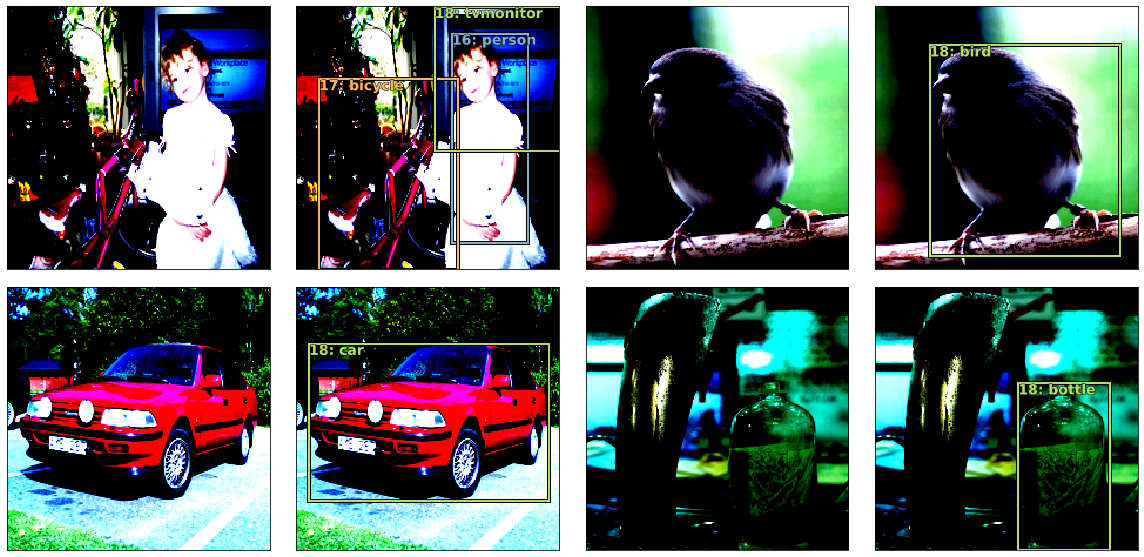

In [58]:
compare(list(range(4)), thresh=0)

In [51]:
p={i:id2cats[str(i)] for i in range(20)}

In [53]:
id2cats=p

done we are just left with traing the model with precision